In [1]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
requirements_pip_compiled = pd.read_csv('../requirements.csv').drop_duplicates(subset="id", keep="first") #remove duplicate files
requirements_pip_compiled = requirements_pip_compiled[["id", "compiled"]].dropna()

requirements_complete = {}

for row in requirements_pip_compiled.iloc:
    lines_with_package = list(filter(lambda x: "==" in x, row["compiled"].split("\n")))
    
    requirements_complete[row["id"]] = \
        list(map(lambda x: x[:x.index("==")], lines_with_package))

In [3]:
def count_packages(file_dict):
    package_count_dict = {}
    for _, deps in file_dict.items():
        for package in deps:
            if package not in package_count_dict:
                package_count_dict[package] = 1
            else:
                package_count_dict[package] += 1

    return pd.DataFrame({"name":package_count_dict.keys(), "count":package_count_dict.values()}).sort_values(by="count", ascending=False)

complete_package_count = count_packages(requirements_complete)

In [4]:
def compute_heatmap(package_count, file_dict):
    package_names = package_count["name"].to_list()
    name_to_ind = {v: i for i, v in enumerate(package_names)}
    heatmap = np.zeros((len(package_names), len(package_names)))
    count_file_per_deps = np.zeros((len(package_names), len(package_names)))
    for k, v in file_dict.items():
        for i in v:
            for j in v:
                if i not in name_to_ind or j not in name_to_ind:
                    continue
                #if i == j : continue
                
                heatmap[name_to_ind[i]][name_to_ind[j]] += 1
                
            count_file_per_deps[name_to_ind[i]] += 1
            
    return heatmap/count_file_per_deps, package_names

complete_txt_heatmap, complete_labels = compute_heatmap(complete_package_count, requirements_complete)

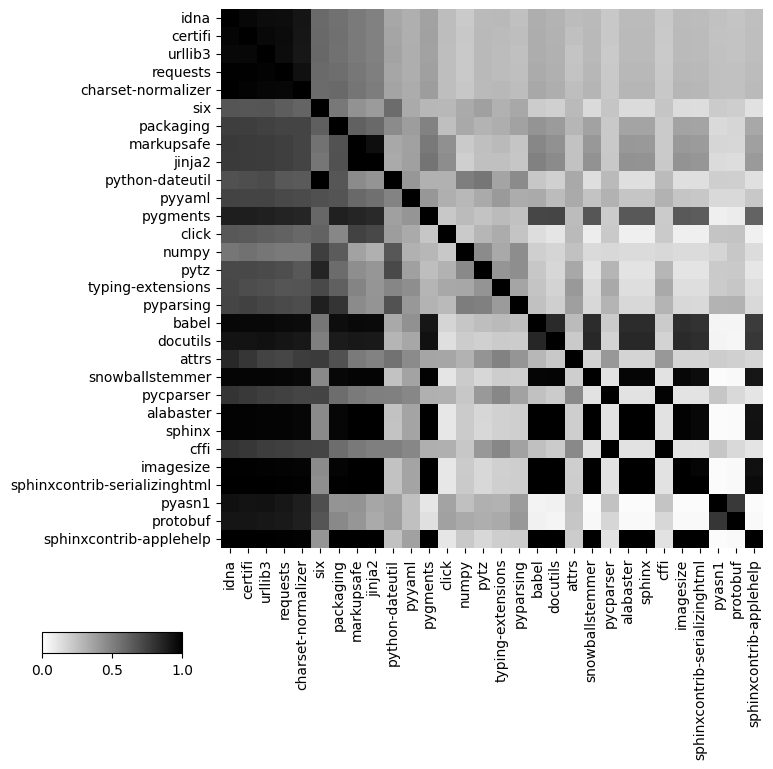

In [15]:
# Clustered heatmap 
import seaborn as sns

df = pd.DataFrame(complete_txt_heatmap, index=complete_labels, columns=complete_labels).iloc[:30, :30]
fig, ax = plt.subplots(figsize=(7, 7))
sns_heatmap = sns.heatmap(df, 
            cmap='binary', 
            yticklabels=True, 
            xticklabels=True,
            cbar=False,
            ax=ax)

sns_heatmap.collections[0].set_clim(0, 1)
cbar_ax = fig.add_axes([-0.13, -0.04, 0.2, 0.03])  # [left, bottom, width, height]
plt.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', ticks=[0.0, 0.5,  1.0])

plt.savefig("complete-heatmap.pdf", format="pdf", bbox_inches="tight")

In [129]:
def parse_req(r):
	skip_prefix = set(['====', '--', '~~~', '{'])
	lines = r.split("\n")
	
	def remove(char, lines):
		return map(lambda x: x[:x.find(char)] if x.find(char) > -1 else x, lines)

	lines = remove("#", lines) #remove comments
	lines = remove("\\", lines)
	lines = remove("--hash", lines)
	lines = list(map(str.strip, lines))


	output = []
	for l in lines:
		skip = False
		for s in skip_prefix:
			if s in l:
				skip = True
		if l == '':
			skip = True
		elif l[0] == '*':
			skip = True

		if not skip:
			a = re.split('(==|!=|>=|<=|<|>|~=|===|;|@)', l)
			a = [item.strip() for item in a]
			if len(a) == 1 and a[0].find(' ') == -1:
				output.append(a)
			elif len(l) >1:
				output.append(a)
			else:
				pass
				#print(l)
		elif l!='' and l!='\n':
			pass
			#print(l)

	return output

In [130]:
df = pd.read_csv('../requirements.csv')
df_unique = df[~df['id'].duplicated()] #some files are duplicated

requirements_raw = {} #key: id,  value: list of packages
COLNUM = 'raw' #'compiled' 
for r in df[['id', COLNUM]].values:
    if pd.isna(r[1]):
        continue
    parsed_req = parse_req(r[1])
    requirements_raw[r[0]] = [x[0] for x in parsed_req] 


In [157]:
raw_package_count = count_packages(requirements_raw)

In [164]:
y_labels = raw_package_count["name"].to_list()
x_labels = complete_package_count["name"].to_list()

y_name_to_ind = {v: i for i, v in enumerate(y_labels)}
x_name_to_ind = {v: i for i, v in enumerate(x_labels)}

heatmap = np.zeros((len(y_labels), len(x_labels)))
count_file_per_deps = np.zeros((len(y_labels), len(x_labels)))
for k, v in requirements_raw.items():
    for i in v:
        if k in requirements_complete:
            for j in requirements_complete[k]:
                if i not in y_name_to_ind or j not in x_name_to_ind:
                    continue
                #if i == j : continue
                
                heatmap[y_name_to_ind[i]][x_name_to_ind[j]] += 1
            
            count_file_per_deps[y_name_to_ind[i]] += 1
        
raw_vs_complete = heatmap/count_file_per_deps

C:\Users\Choik\AppData\Local\Temp\ipykernel_11748\946268070.py:21: RuntimeWarning: invalid value encountered in divide
  raw_vs_complete = heatmap/count_file_per_deps


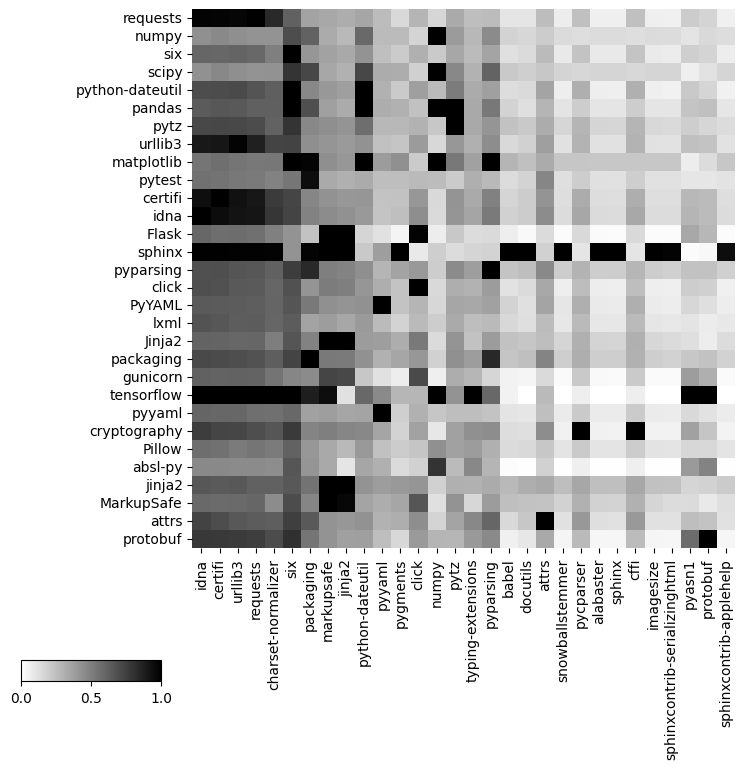

In [166]:
# Clustered heatmap 
df = pd.DataFrame(raw_vs_complete, index=y_labels, columns=x_labels).iloc[:30, :30]
fig, ax = plt.subplots(figsize=(7, 7))
sns_heatmap = sns.heatmap(df, 
            cmap='binary', 
            yticklabels=True, 
            xticklabels=True,
            cbar=False,
            ax=ax)

sns_heatmap.collections[0].set_clim(0, 1)
cbar_ax = fig.add_axes([-0.12, -0.08, 0.2, 0.03])  # [left, bottom, width, height]
plt.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal', ticks=[0.0, 0.5,  1.0])

plt.savefig("raw-complete-heatmap.pdf", format="pdf", bbox_inches="tight")